### Hydrogen

In [12]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms import NumPyMinimumEigensolver

### Una distancia

https://qiskit-community.github.io/qiskit-nature/locale/es_UN/migration/0.6_c_qubit_converter.html#

In [3]:
driver = PySCFDriver(
    atom=f"H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
mapper = JordanWignerMapper()

fermionic_op = problem.hamiltonian.second_q_op()

qubit_op = mapper.map(fermionic_op)

/home/tfg/TFG/tfg_env/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
# define ansatz and optimizer
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

In [5]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

print(noise_model)

/tmp/ipykernel_1567/1013747364.py:6: DeprecationWarning: All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. These classes are deprecated as of qiskit 0.46.0 and will be removed in qiskit 1.0.0. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. If you are using a custom fake backend implementation, you don't need to take any action.
  device = FakeVigo()


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'sx', 'measure', 'x', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [6]:
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [7]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=qubit_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


In [8]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [9]:
# re-start callback variables
counts = []
values = []

vqe = VQE(
    noisy_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

result_vqe = vqe.compute_minimum_eigenvalue(operator=qubit_op)

print(f"VQE on Aer qasm simulator (with noise): {result_vqe.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_vqe.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (with noise): -1.69362
Delta from reference energy value is 0.16366


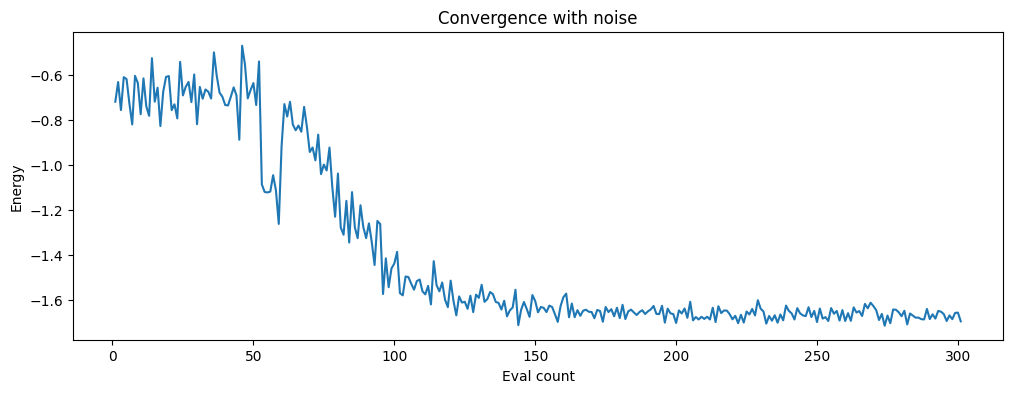

In [10]:
import pylab

if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

### Barrido distancias

In [13]:
# define ansatz and optimizer
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

"""
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Build noise model from backend properties
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')
noise_model = NoiseModel.from_backend(backend)

-----

from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)


from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
"""

# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [14]:
import numpy as np

distances = np.linspace(0.25, 4, 200)
energies = []
energies_vqe = []

def vqe_distance(distance, counts, values):
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    mapper = JordanWignerMapper()
    fermionic_op = problem.hamiltonian.second_q_op()
    qubit_op = mapper.map(fermionic_op)

    
    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)


    # re-start callback variables
    counts = []
    values = []

    """
    vqe.estimator = noisy_estimator
    """
    result_vqe = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    
    return [hamiltonian, result, result_vqe]

shots = 1024

In [15]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

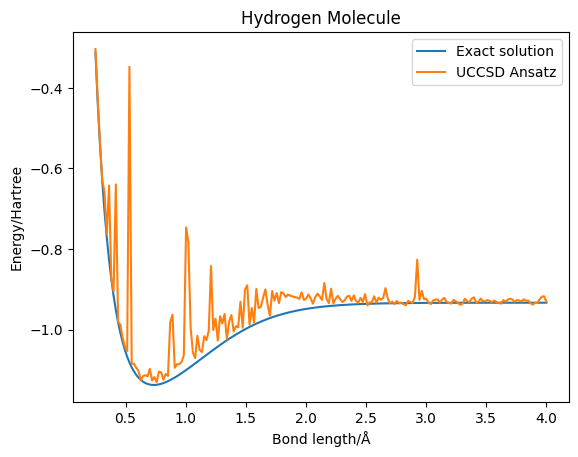

In [16]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.linspace(0.25, 4, 200)
energies = []
energies_vqe = []

for distance in distances:
    hamiltonian, result, result_vqe = vqe_distance(distance, counts, values)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)
    energies_vqe.append(result_vqe.eigenvalue.real + hamiltonian.nuclear_repulsion_energy)


plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

In [17]:
import csv
import os

directorio = 'results'
if not os.path.exists(directorio):
    os.makedirs(directorio)

nombre_archivo = '1024_shots.csv'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open(ruta_archivo, mode='w', newline='') as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerow(['distance', 'energy', 'energy_vqe'])
    for x, y, z in zip(distances, energies, energies_vqe):
        escritor_csv.writerow([x, y, z])

shots = 128

In [51]:
"""
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 128},
    transpile_options={"seed_transpiler": seed},
)
"""

'\nnoisy_estimator = AerEstimator(\n    backend_options={\n        "method": "density_matrix",\n        "coupling_map": coupling_map,\n        "noise_model": noise_model,\n    },\n    run_options={"seed": seed, "shots": 128},\n    transpile_options={"seed_transpiler": seed},\n)\n'

In [52]:
from qiskit_algorithms.utils import algorithm_globals

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 128},
    transpile_options={"seed_transpiler": seed},
)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

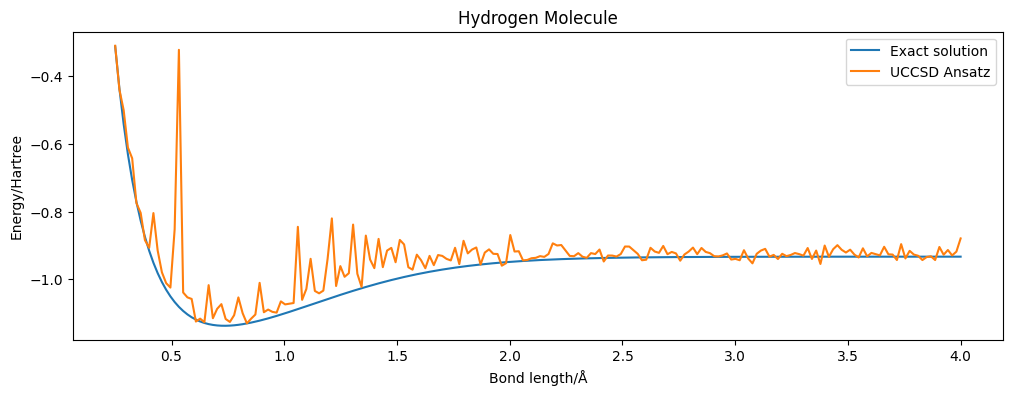

In [55]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.linspace(0.25, 4, 200)
energies = []
energies_vqe = []

for distance in distances:
    hamiltonian, result, result_vqe = vqe_distance(distance, counts, values)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)
    energies_vqe.append(result_vqe.eigenvalue.real + hamiltonian.nuclear_repulsion_energy)


plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

In [56]:
import csv
import os

directorio = 'results'
if not os.path.exists(directorio):
    os.makedirs(directorio)

nombre_archivo = '128_shots.csv'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open(ruta_archivo, mode='w', newline='') as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerow(['distance', 'energy', 'energy_vqe'])
    for x, y, z in zip(distances, energies, energies_vqe):
        escritor_csv.writerow([x, y, z])

shots = 16

In [57]:
"""
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 16},
    transpile_options={"seed_transpiler": seed},
)
"""

'\nnoisy_estimator = AerEstimator(\n    backend_options={\n        "method": "density_matrix",\n        "coupling_map": coupling_map,\n        "noise_model": noise_model,\n    },\n    run_options={"seed": seed, "shots": 16},\n    transpile_options={"seed_transpiler": seed},\n)\n'

In [58]:
from qiskit_algorithms.utils import algorithm_globals

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 16},
    transpile_options={"seed_transpiler": seed},
)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

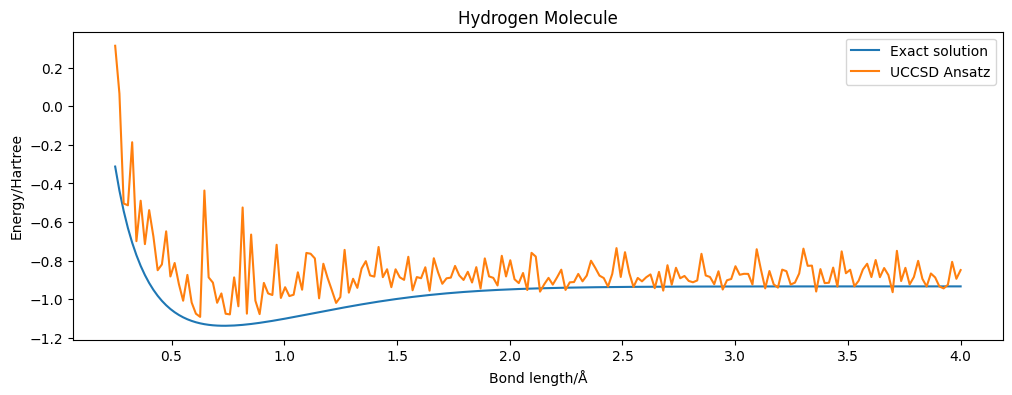

In [59]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.linspace(0.25, 4, 200)
energies = []
energies_vqe = []

for distance in distances:
    hamiltonian, result, result_vqe = vqe_distance(distance, counts, values)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)
    energies_vqe.append(result_vqe.eigenvalue.real + hamiltonian.nuclear_repulsion_energy)


plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

In [60]:
import csv
import os

directorio = 'results'
if not os.path.exists(directorio):
    os.makedirs(directorio)

nombre_archivo = '16_shots.csv'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open(ruta_archivo, mode='w', newline='') as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerow(['distance', 'energy', 'energy_vqe'])
    for x, y, z in zip(distances, energies, energies_vqe):
        escritor_csv.writerow([x, y, z])

shots = 2**14

In [4]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 2**14},
    transpile_options={"seed_transpiler": seed},
)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

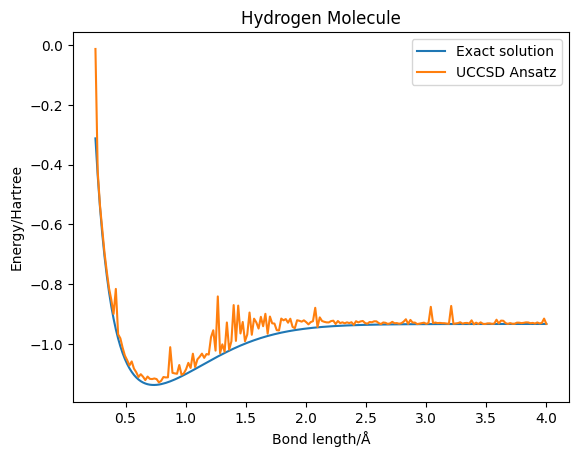

In [10]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.linspace(0.25, 4, 200)
energies = []
energies_vqe = []

for distance in distances:
    hamiltonian, result, result_vqe = vqe_distance(distance, counts, values)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)
    energies_vqe.append(result_vqe.eigenvalue.real + hamiltonian.nuclear_repulsion_energy)


plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

In [11]:
import csv
import os

directorio = 'results'
if not os.path.exists(directorio):
    os.makedirs(directorio)

nombre_archivo = '16384_shots.csv'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open(ruta_archivo, mode='w', newline='') as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerow(['distance', 'energy', 'energy_vqe'])
    for x, y, z in zip(distances, energies, energies_vqe):
        escritor_csv.writerow([x, y, z])